<a href="https://colab.research.google.com/github/nbisso/TP2-Orga-7506/blob/main/prueba_con_xgboost_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
!pip install --upgrade category_encoders
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import category_encoders as ce
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV
import pytz

In [168]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Levanto la data de los DFS

In [169]:
train_labels = pd.read_csv('/content/drive/MyDrive/datasets_tp2/train_labels.csv')
train_values = pd.read_csv('/content/drive/MyDrive/datasets_tp2/train_values.csv')
df_test = pd.read_csv('/content/drive/MyDrive/datasets_tp2/test_values.csv')
train_values_with_prob = pd.read_csv('/content/drive/MyDrive/datasets_tp2/train_values_with_prob.csv')
train_values_with_prob = train_values_with_prob.iloc[:,1:]

In [170]:

if (len(train_values_with_prob) == 0):
  fea = pd.merge(train_values, train_labels, on='building_id')
  damage1 = {}
  damage2 = {}
  damage3 = {}
  for i,j in (train_values['geo_level_1_id'].value_counts()).iteritems():
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])
    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
  list1 = []
  list2 = []
  list3 = []
  for i in train_values['geo_level_1_id']:
      list1.append(damage1.get(i))
      list2.append(damage2.get(i))
      list3.append(damage3.get(i))
  train_values['prob1_geo1'] = list1
  train_values['prob2_geo1'] = list2
  train_values['prob3_geo1'] = list3

  damage1 = {}
  damage2 = {}
  damage3 = {}
  for i,j in (train_values['geo_level_2_id'].value_counts()).iteritems():
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])
    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
  list1 = []
  list2 = []
  list3 = []
  for i in train_values['geo_level_2_id']:
      list1.append(damage1.get(i))
      list2.append(damage2.get(i))
      list3.append(damage3.get(i))
  train_values['prob1_geo2'] = list1
  train_values['prob2_geo2'] = list2
  train_values['prob3_geo2'] = list3


  damage1 = {}
  damage2 = {}
  damage3 = {}
  for i,j in (train_values['geo_level_3_id'].value_counts()).iteritems():
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])
    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
  list1 = []
  list2 = []
  list3 = []
  for i in train_values['geo_level_3_id']:
      list1.append(damage1.get(i))
      list2.append(damage2.get(i))
      list3.append(damage3.get(i))
  train_values['prob1_geo3'] = list1
  train_values['prob2_geo3'] = list2
  train_values['prob3_geo3'] = list3
  train_values.to_csv('/content/drive/MyDrive/datasets_tp2/train_values_with_prob.csv')
  

train_values = train_values_with_prob


In [171]:
df_test

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0
86864,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
86865,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
86866,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0


In [172]:
for k in range(1, 4):
  df_train_without_dp = train_values[["prob1_geo" + str(k),"prob2_geo"+ str(k),"prob3_geo"+ str(k),"geo_level_" + str(k) + "_id"]].drop_duplicates()
  df_test = df_test.merge(df_train_without_dp,on="geo_level_" + str(k) + "_id",how="left")
  df_test[df_test["prob1_geo" + str(k)] == 0]["prob1_geo" + str(k)] = df_test["prob1_geo" + str(k)].mean()
  df_test[df_test["prob2_geo" + str(k)] == 0]["prob2_geo" + str(k)] = df_test["prob2_geo" + str(k)].mean()
  df_test[df_test["prob3_geo" + str(k)] == 0]["prob3_geo" + str(k)] = df_test["prob3_geo" + str(k)].mean()

df_test
# df_test= df_test.drop(columns=["geo_level_1_id","geo_level_2_id","geo_level_3_id"])
# train_values= train_values.drop(columns=["geo_level_1_id","geo_level_2_id","geo_level_3_id"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.007194,0.280576,0.712230,0.052632,0.263158,0.684211
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,0.086461,0.665354,0.248185,0.000000,0.819149,0.180851,0.000000,1.000000,0.000000
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.129718,0.739603,0.130678,0.000000,0.825000,0.175000,0.000000,0.000000,1.000000
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.571429,0.419355,0.009217
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.005181,0.300518,0.694301,0.000000,0.176471,0.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,0.035763,0.766337,0.197900,0.056604,0.764151,0.179245,0.194444,0.750000,0.055556
86864,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.054848,0.548349,0.396802,0.060519,0.541787,0.397695,0.000000,0.277778,0.722222
86865,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.129718,0.739603,0.130678,0.083744,0.812808,0.103448,0.090909,0.909091,0.000000
86866,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0,0.086461,0.665354,0.248185,0.065421,0.573209,0.361371,0.090909,0.681818,0.227273


In [173]:
train_labels

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
...,...,...
260596,688636,2
260597,669485,3
260598,602512,3
260599,151409,2


In [174]:
train_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.086461,0.665354,0.248185,0.003704,0.251852,0.744444,0.000000,0.162162,0.837838
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.034277,0.446174,0.519549,0.010050,0.492462,0.497487,0.062500,0.812500,0.125000
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.021627,0.393378,0.584996,0.082386,0.316477,0.601136,0.029412,0.360294,0.610294
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.129718,0.739603,0.130678,0.019512,0.853659,0.126829,0.032258,0.838710,0.129032
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.046959,0.568370,0.384672,0.029865,0.591522,0.378613,0.008197,0.614754,0.377049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.083215,0.779516,0.137269,0.172414,0.724138,0.103448,0.000000,0.928571,0.071429
260597,669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.003831,0.061303,0.934866,0.000000,0.020408,0.979592
260598,602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.024024,0.057057,0.918919,0.045455,0.090909,0.863636
260599,151409,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.220339,0.766949,0.012712


In [175]:
df_test

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.007194,0.280576,0.712230,0.052632,0.263158,0.684211
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,0.086461,0.665354,0.248185,0.000000,0.819149,0.180851,0.000000,1.000000,0.000000
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.129718,0.739603,0.130678,0.000000,0.825000,0.175000,0.000000,0.000000,1.000000
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.571429,0.419355,0.009217
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.005181,0.300518,0.694301,0.000000,0.176471,0.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,0.035763,0.766337,0.197900,0.056604,0.764151,0.179245,0.194444,0.750000,0.055556
86864,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.054848,0.548349,0.396802,0.060519,0.541787,0.397695,0.000000,0.277778,0.722222
86865,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0.129718,0.739603,0.130678,0.083744,0.812808,0.103448,0.090909,0.909091,0.000000
86866,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0,0.086461,0.665354,0.248185,0.065421,0.573209,0.361371,0.090909,0.681818,0.227273


Feature Engineering

Usamos BinaryEncoder de los categoricos

In [176]:
encoder= ce.BinaryEncoder(cols= ['land_surface_condition', 'foundation_type', \
                                 'roof_type', 'ground_floor_type', 'other_floor_type',\
                                 'position', 'plan_configuration', 'legal_ownership_status'], return_df = True)

df_train_encoding = encoder.fit_transform(train_values)
df_test_encoding = encoder.fit_transform(df_test)

df_train_encoding=df_train_encoding.drop(columns=["land_surface_condition_0","foundation_type_0","roof_type_0","ground_floor_type_0","plan_configuration_0"])
df_test_encoding=df_test_encoding.drop(columns=["land_surface_condition_0","foundation_type_0","roof_type_0","ground_floor_type_0","plan_configuration_0"])


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [177]:
# df_train_encoding=df_train_encoding.drop(columns=["has_secondary_use_use_police"])
# df_test_encoding=df_test_encoding.drop(columns=["has_secondary_use_use_police"])

# df_train_encoding=df_train_encoding.drop(columns=["has_secondary_use_health_post"])
# df_test_encoding=df_test_encoding.drop(columns=["has_secondary_use_health_post"])

In [178]:
df_train_encoding

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition_1,land_surface_condition_2,foundation_type_1,foundation_type_2,foundation_type_3,roof_type_1,roof_type_2,ground_floor_type_1,ground_floor_type_2,ground_floor_type_3,other_floor_type_0,other_floor_type_1,other_floor_type_2,position_0,position_1,position_2,plan_configuration_1,plan_configuration_2,plan_configuration_3,plan_configuration_4,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status_0,legal_ownership_status_1,legal_ownership_status_2,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,802906,6,487,12198,2,30,6,5,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.086461,0.665354,0.248185,0.003704,0.251852,0.744444,0.000000,0.162162,0.837838
1,28830,8,900,2812,2,10,8,7,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.034277,0.446174,0.519549,0.010050,0.492462,0.497487,0.062500,0.812500,0.125000
2,94947,21,363,8973,2,10,5,5,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.021627,0.393378,0.584996,0.082386,0.316477,0.601136,0.029412,0.360294,0.610294
3,590882,22,418,10694,2,10,6,5,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.129718,0.739603,0.130678,0.019512,0.853659,0.126829,0.032258,0.838710,0.129032
4,201944,11,131,1488,3,30,8,9,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.046959,0.568370,0.384672,0.029865,0.591522,0.378613,0.008197,0.614754,0.377049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,1,1,0,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.083215,0.779516,0.137269,0.172414,0.724138,0.103448,0.000000,0.928571,0.071429
260597,669485,17,715,2060,2,0,6,5,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.003831,0.061303,0.934866,0.000000,0.020408,0.979592
260598,602512,17,51,8163,3,55,6,7,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.024024,0.057057,0.918919,0.045455,0.090909,0.863636
260599,151409,26,39,1851,2,10,14,6,0,1,0,0,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.220339,0.766949,0.012712


In [179]:
df_test_encoding

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition_1,land_surface_condition_2,foundation_type_1,foundation_type_2,foundation_type_3,roof_type_1,roof_type_2,ground_floor_type_1,ground_floor_type_2,ground_floor_type_3,other_floor_type_0,other_floor_type_1,other_floor_type_2,position_0,position_1,position_2,plan_configuration_1,plan_configuration_2,plan_configuration_3,plan_configuration_4,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status_0,legal_ownership_status_1,legal_ownership_status_2,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,300051,17,596,11307,3,20,7,6,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.007194,0.280576,0.712230,0.052632,0.263158,0.684211
1,99355,6,141,11987,2,25,13,5,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0.086461,0.665354,0.248185,0.000000,0.819149,0.180851,0.000000,1.000000,0.000000
2,890251,22,19,10044,2,5,4,5,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.129718,0.739603,0.130678,0.000000,0.825000,0.175000,0.000000,0.000000,1.000000
3,745817,26,39,633,1,0,19,3,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,0,0,1,0,0,0,0,0,0,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.571429,0.419355,0.009217
4,421793,17,289,7970,3,15,8,7,0,1,0,0,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.013066,0.179388,0.807546,0.005181,0.300518,0.694301,0.000000,0.176471,0.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,0,1,0,0,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0.035763,0.766337,0.197900,0.056604,0.764151,0.179245,0.194444,0.750000,0.055556
86864,663567,10,1407,11907,3,25,6,7,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.054848,0.548349,0.396802,0.060519,0.541787,0.397695,0.000000,0.277778,0.722222
86865,1049160,22,1136,7712,1,50,3,3,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.129718,0.739603,0.130678,0.083744,0.812808,0.103448,0.090909,0.909091,0.000000
86866,442785,6,1041,912,2,5,9,5,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.086461,0.665354,0.248185,0.065421,0.573209,0.361371,0.090909,0.681818,0.227273


Armamos y entrenamos el modelo XGBOOST

In [180]:
df_test_encoding = df_test_encoding.iloc[:,1:]
X = df_train_encoding.iloc[:, 1:]
y = train_labels.iloc[:, 1:]

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [211]:
xgb_cl = xgb.XGBClassifier( base_score=0.5, 
                            booster='gbtree', 
                            colsample_bylevel=1,
                            colsample_bynode=1, 
                            colsample_bytree=0.5, 
                            gamma=0.25, 
                            importance_type='gain',
                            interaction_constraints='',
                            learning_rate=0.1,
                            max_delta_step=0, 
                            max_depth=8,
                            min_child_weight=7,
                            n_estimators=200, 
                            n_jobs=-1, 
                            num_parallel_tree=1, 
                            random_state=0,
                            reg_alpha=0, 
                            reg_lambda=0, 
                            scale_pos_weight=1, 
                            subsample=1,
                            tree_method='exact', 
                            validate_parameters=1, 
                            verbosity=1)

In [ ]:
        # param_grid = {
#     # "max_depth": [3, 4, 5, 7],
#     # "learning_rate": [0.1, 0.01, 0.05],
#     # "gamma": [0, 0.25, 1],
#     # "reg_lambda": [0, 1, 10],
#     # "scale_pos_weight": [1, 3, 5],
#     # "subsample": [0.8],
#     "colsample_bytree": [0.5,1],
#     "colsample_bynode": [0.5,1],
#     "colsample_bylevel": [0.5,1],
# }

# grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3)


# _ = grid_cv.fit(X_train,y_train)
xgb_cl.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


hago el predict de los valores de test

In [202]:
pred_xgboost = xgb_cl.predict(X_test)

In [203]:
f1_score(y_test, pred_xgboost, average ='micro')

0.7547437693060378

In [204]:
# grid_cv.best_params_

<BarContainer object of 62 artists>

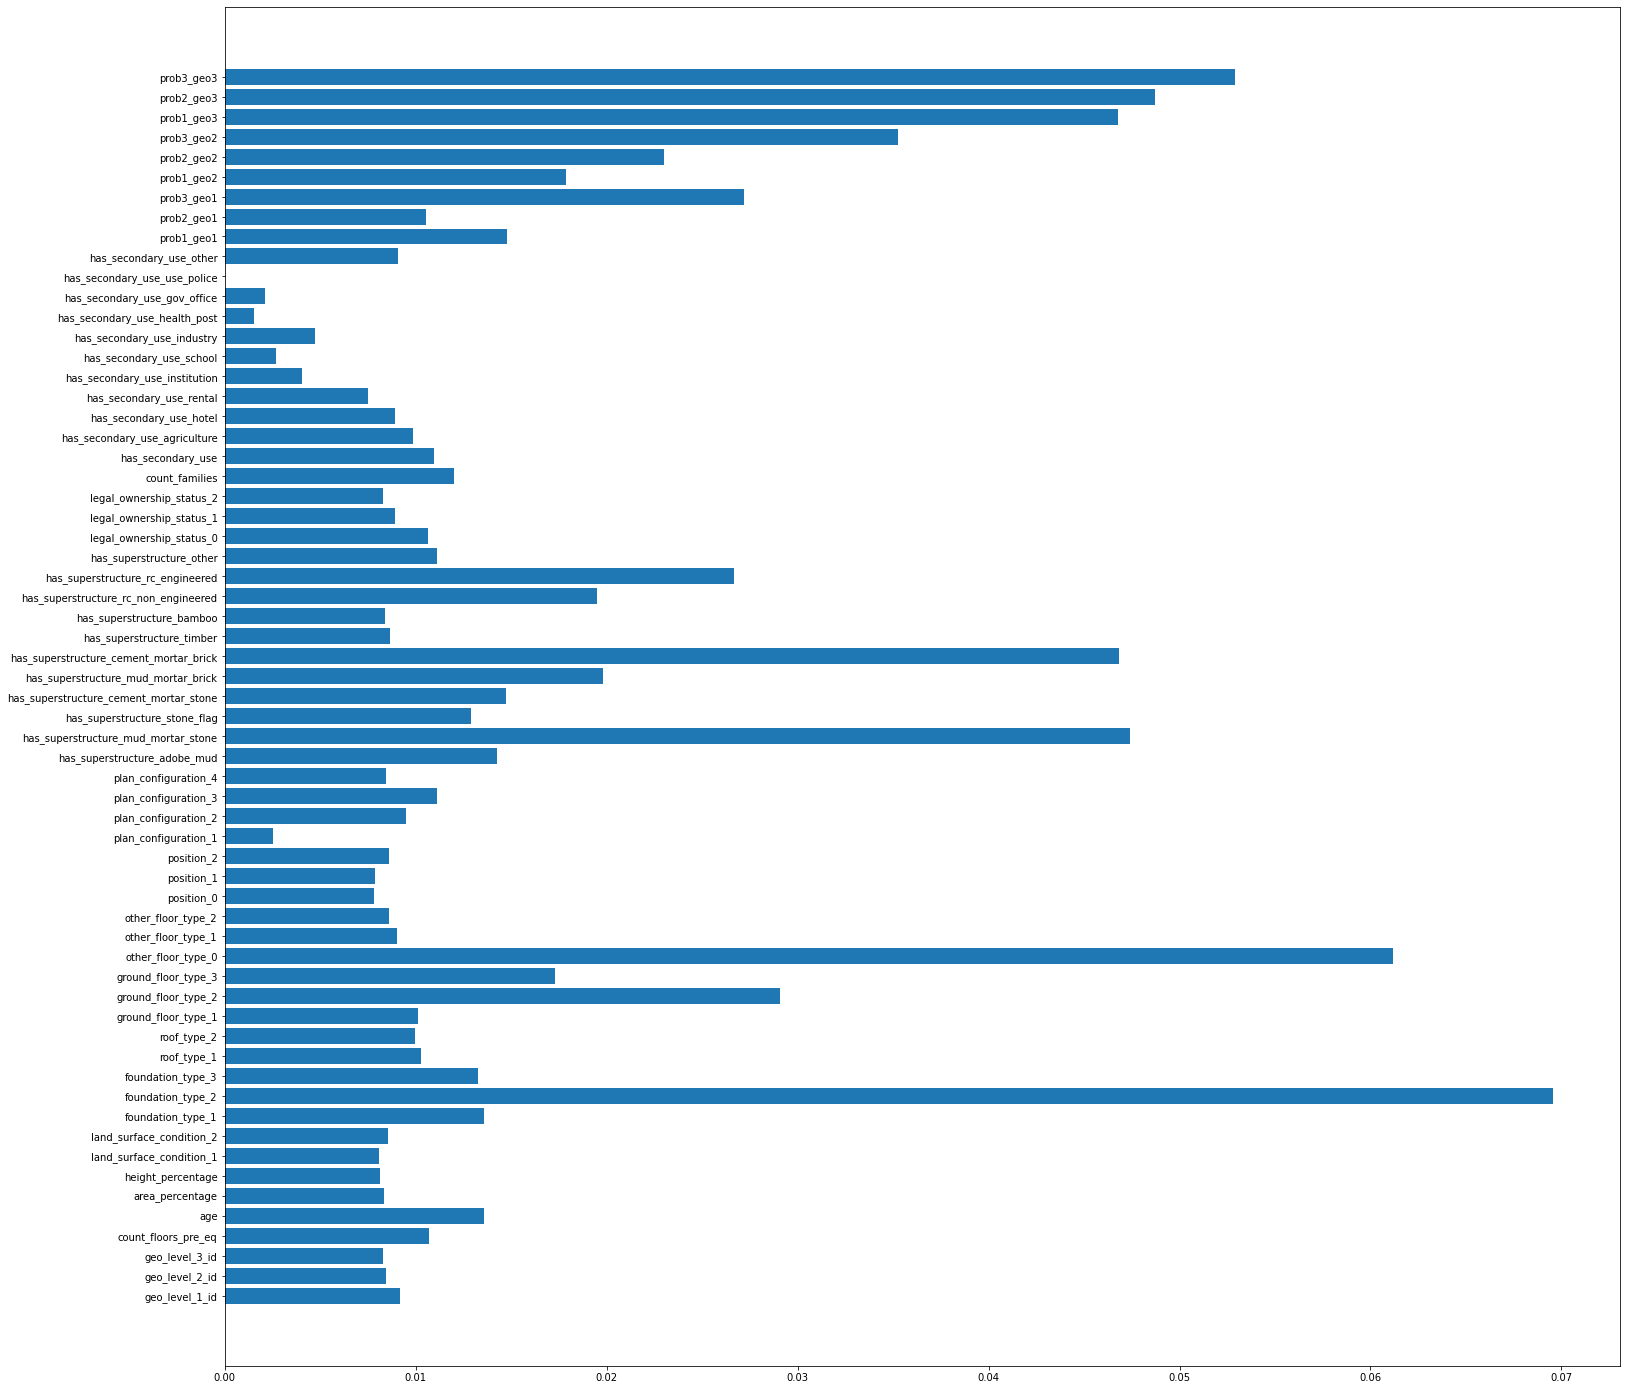

In [205]:
plt.figure(figsize=(25,25))
plt.barh(X.columns, xgb_cl.feature_importances_)


In [206]:
node_params = {'shape' : 'box',
              'style': 'filled, rounded',
               'fillcolor' : '#78cbe'}

leaf_params = {'shape' : 'box',
              'style': 'filled',
               'fillcolor' : '#e48038'}

xgb.to_graphviz(xgb_cl,num_trees=0,size="600,600",condition_node_params=node_params,leaf_node_params=leaf_params)

predigo el df_test y creo el file contra el format csv

In [207]:
pred_xgboost_final = xgb_cl.predict(df_test_encoding)


In [208]:
pred_xgboost_final

array([3, 2, 3, ..., 2, 2, 2])

In [209]:
submission_format = pd.read_csv('/content/drive/MyDrive/datasets_tp2/submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=pred_xgboost_final,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [210]:
fecha = datetime.datetime.now(pytz.timezone("Etc/GMT+3"))
my_submission.to_csv('/content/drive/MyDrive/datasets_tp2/' + fecha.strftime("%d%b%Y %H:%M") +'_training-result.csv',index= True)